<a href="https://colab.research.google.com/github/sidt-ai/data-science-competitions/blob/main/dphi/ds75-child-healthcare/notebooks/01_eda_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import gc
import time
import warnings

gc.enable()
warnings.filterwarnings('ignore')

%pprint

Pretty printing has been turned OFF


In [ ]:
import numpy as np
from scipy.stats import mode, ttest_ind
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
SEED = 2311

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
train_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/dphi/ds75-child-healthcare/data/train_dataset.csv'
test_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/dphi/ds75-child-healthcare/data/test_dataset.csv'

In [ ]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# EDA + Preprocessing

In [ ]:
train.shape, test.shape

((1488, 22), (638, 21))

In [ ]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          1488 non-null   float64
 1   accelerations                                           1488 non-null   float64
 2   fetal_movement                                          1488 non-null   float64
 3   uterine_contractions                                    1488 non-null   float64
 4   light_decelerations                                     1488 non-null   float64
 5   severe_decelerations                                    1488 non-null   float64
 6   prolongued_decelerations                                1488 non-null   float64
 7   abnormal_short_term_variability                         1488 non-null   float64
 8   mean_value_of_short_term_variability  

In [ ]:
train.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,133.0,0.003,0.000,0.004,0.004,0.0,0.000,30.0,1.5,0.0,5.3,102.0,67.0,169.0,9.0,1.0,147.0,137.0,144.0,40.0,1.0,1.0
1,130.0,0.001,0.001,0.012,0.010,0.0,0.001,62.0,2.2,0.0,0.0,161.0,50.0,211.0,9.0,0.0,60.0,89.0,113.0,250.0,0.0,3.0
2,141.0,0.000,0.008,0.000,0.000,0.0,0.000,75.0,0.3,49.0,4.6,9.0,136.0,145.0,1.0,0.0,143.0,141.0,143.0,0.0,1.0,2.0
3,144.0,0.000,0.002,0.002,0.000,0.0,0.000,84.0,0.3,34.0,5.5,38.0,132.0,170.0,2.0,0.0,144.0,143.0,145.0,0.0,-1.0,3.0
4,106.0,0.001,0.000,0.011,0.000,0.0,0.000,63.0,0.6,0.0,11.5,30.0,95.0,125.0,1.0,0.0,112.0,110.0,112.0,1.0,0.0,1.0


In [ ]:
train.nunique()

baseline value                                             48
accelerations                                              20
fetal_movement                                             83
uterine_contractions                                       16
light_decelerations                                        16
severe_decelerations                                        2
prolongued_decelerations                                    6
abnormal_short_term_variability                            75
mean_value_of_short_term_variability                       54
percentage_of_time_with_abnormal_long_term_variability     83
mean_value_of_long_term_variability                       231
histogram_width                                           152
histogram_min                                             107
histogram_max                                              84
histogram_number_of_peaks                                  18
histogram_number_of_zeroes                                  9
histogra

In [ ]:
features = test.columns.to_list()
TARGET = 'fetal_health'

In [ ]:
def plot_grouped(col, discrete=True):
    
    plt.figure(figsize=(20, 5))
    
    if discrete:
        ax = sns.countplot(x=col, data=train, hue=TARGET, palette='dark')
        ax.set_ylabel('count', fontsize=10, fontweight='bold')
        ax.legend(loc='upper right')
        for p in ax.patches:
            val = 0 if np.isnan(p.get_height()) else p.get_height()
            ax.text(
                (p.get_x() + p.get_width()/2), (val + 0.5), 
                int(val), 
                horizontalalignment='center', fontsize=9)
    else:
        ax = sns.kdeplot(x=col, data=train, hue=TARGET, palette='dark')
        ax.set_ylabel('density', fontsize=10, fontweight='bold')
    
    ax.set_title('\'' + col + '\' distribution grouped by target column', 
                 fontsize=15, fontweight='bold')   
    ax.set_xlabel(col, fontsize=10, fontweight='bold')
    
    plt.show()

In [ ]:
def explore_column(col, discrete=True):

    if discrete:
        print(f'Number of unique values: train - {train[col].nunique()}, test - {test[col].nunique()}')
        print(f'\nUnique values:\ntrain - {sorted(train[col].unique())}\
        \ntest - {sorted(test[col].unique())}')
        print(f'\nUnseen values in test set: {bool(set(test[col].unique()) - set(train[col].unique()))}\n')
    else:
        print(f'Range of values: train - {train[col].min()} to {train[col].max()}, test - {test[col].min()} to {test[col].max()}')
        print(f'\nMean: train - {train[col].mean():.4f}, test - {test[col].mean():.4f}')
        print(f'Median: train - {train[col].median()}, test - {test[col].median()}\n')
        
    plot_grouped(col, discrete=discrete)

### TARGET: fetal_health

In [ ]:
train[TARGET].value_counts()

1.0    1158
2.0     207
3.0     123
Name: fetal_health, dtype: int64

In [ ]:
train[TARGET].value_counts(normalize=True)

1.0    0.7782
2.0    0.1391
3.0    0.0827
Name: fetal_health, dtype: float64

In [ ]:
train[TARGET] = train[TARGET].astype('int')

## Feature distributions

### baseline value

Range of values: train - 106.0 to 160.0, test - 110.0 to 159.0

Mean: train - 133.1008, test - 133.7774
Median: train - 133.0, test - 133.0



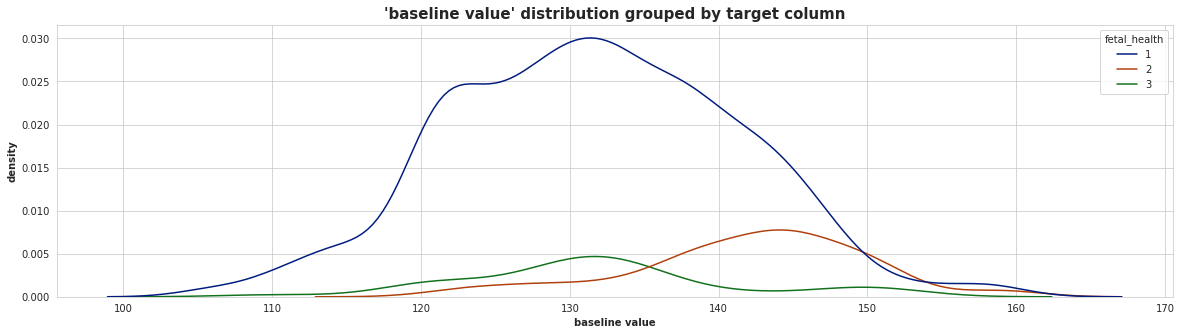

In [ ]:
explore_column('baseline value', discrete=False)

Higher baseline value -> higher probability of abnormal condition

In [ ]:
train['baseline value'] = train['baseline value'].astype('int')
test['baseline value'] = test['baseline value'].astype('int')

### accelerations

Number of unique values: train - 20, test - 19

Unique values:
train - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019]        
test - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018]

Unseen values in test set: False



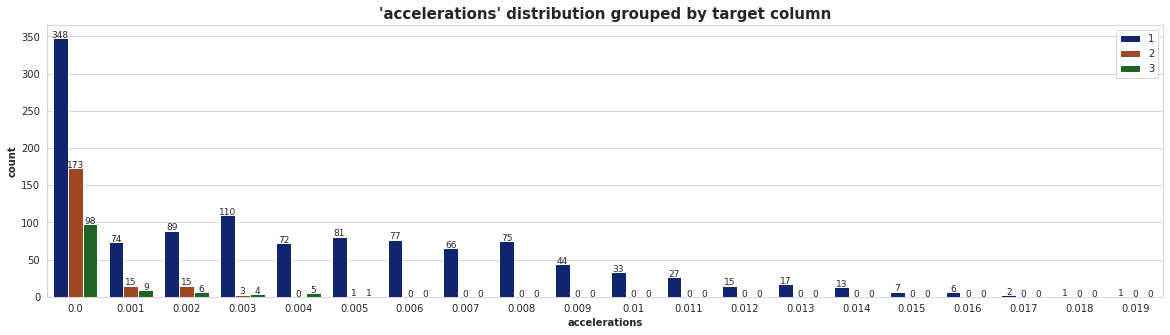

In [ ]:
explore_column('accelerations', discrete=True)

Range of values: train - 0.0 to 0.019, test - 0.0 to 0.018

Mean: train - 0.0032, test - 0.0031
Median: train - 0.002, test - 0.001



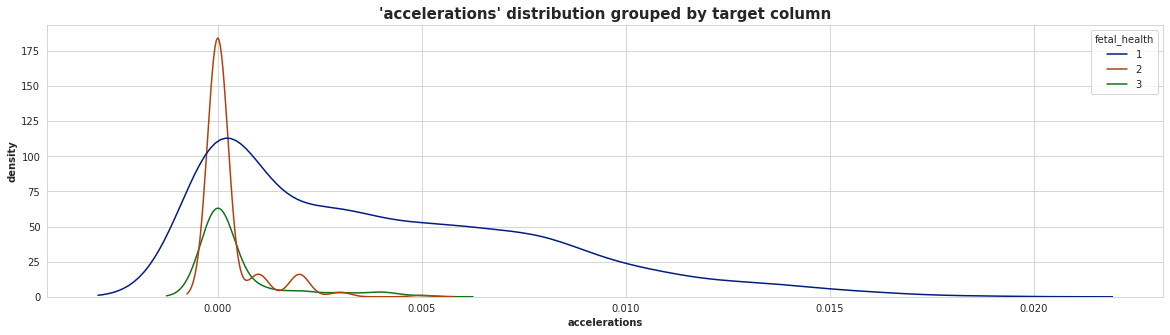

In [ ]:
explore_column('accelerations', discrete=False)

Abnormal condition is detected only in low *accelerations* but the feature is also heavily imbalanced. 

In [ ]:
train['accelerations'] = train['accelerations'].apply(lambda x: x * 1000).astype('int')
test['accelerations'] = test['accelerations'].apply(lambda x: x * 1000).astype('int')

### fetal_movement

Range of values: train - 0.0 to 0.481, test - 0.0 to 0.477

Mean: train - 0.0093, test - 0.0099
Median: train - 0.0, test - 0.0



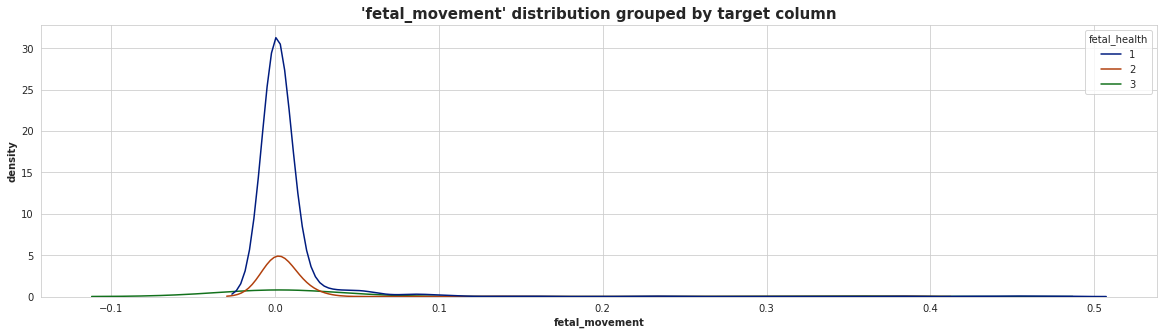

In [ ]:
explore_column('fetal_movement', discrete=False)

Heavily imbalanced with most values around 0.

In [ ]:
train['fetal_movement'] = train['fetal_movement'].apply(lambda x: x * 1000).astype('int')
test['fetal_movement'] = test['fetal_movement'].apply(lambda x: x * 1000).astype('int')

### uterine_contractions

Number of unique values: train - 16, test - 14

Unique values:
train - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]        
test - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.014]

Unseen values in test set: False



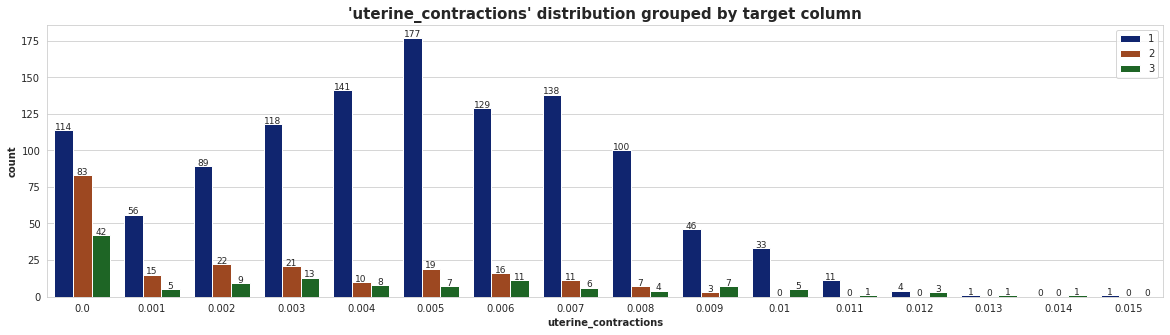

In [ ]:
explore_column('uterine_contractions', discrete=True)

Abnormal conditions are relatively frequent for lower *uterine_contractions*.

Range of values: train - 0.0 to 0.015, test - 0.0 to 0.014

Mean: train - 0.0044, test - 0.0044
Median: train - 0.004, test - 0.004



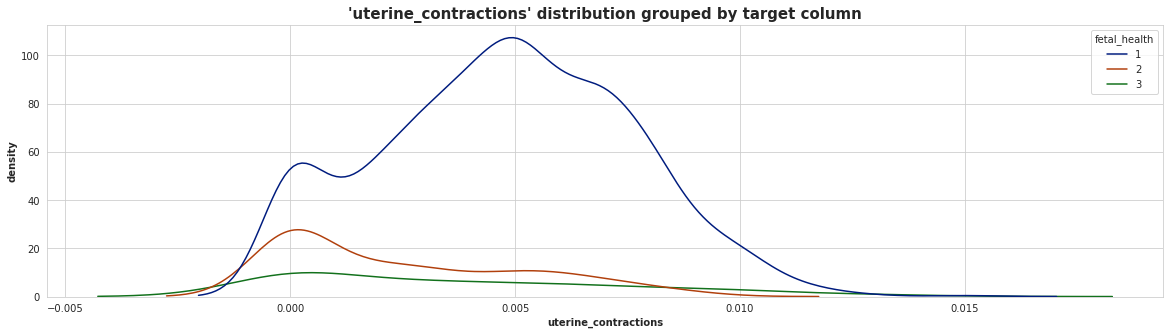

In [ ]:
explore_column('uterine_contractions', discrete=False)

In [ ]:
train['uterine_contractions'] = train['uterine_contractions'].apply(lambda x: x * 1000).astype('int')
test['uterine_contractions'] = test['uterine_contractions'].apply(lambda x: x * 1000).astype('int')

### light_decelerations

Number of unique values: train - 16, test - 15

Unique values:
train - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]        
test - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]

Unseen values in test set: False



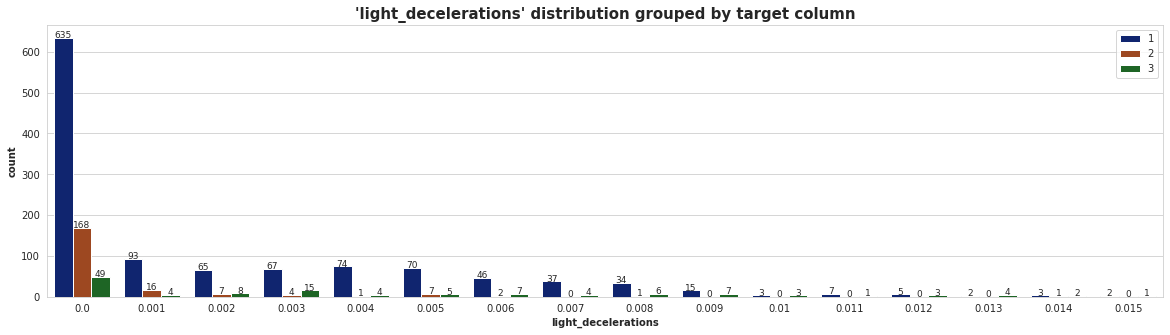

In [ ]:
explore_column('light_decelerations', discrete=True)

Range of values: train - 0.0 to 0.015, test - 0.0 to 0.014

Mean: train - 0.0019, test - 0.0018
Median: train - 0.0, test - 0.0



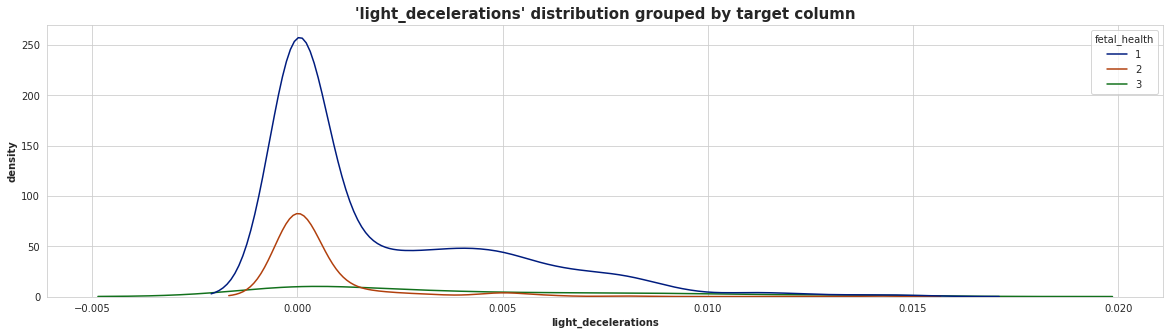

In [ ]:
explore_column('light_decelerations', discrete=False)

Heavily imbalanced with most values around 0. Most abnormal conditions are also recorded at lower *light_decelerations*.

In [ ]:
train['light_decelerations'] = train['light_decelerations'].apply(lambda x: x * 1000).astype('int')
test['light_decelerations'] = test['light_decelerations'].apply(lambda x: x * 1000).astype('int')

### severe_decelerations

Number of unique values: train - 2, test - 2

Unique values:
train - [0.0, 0.001]        
test - [0.0, 0.001]

Unseen values in test set: False



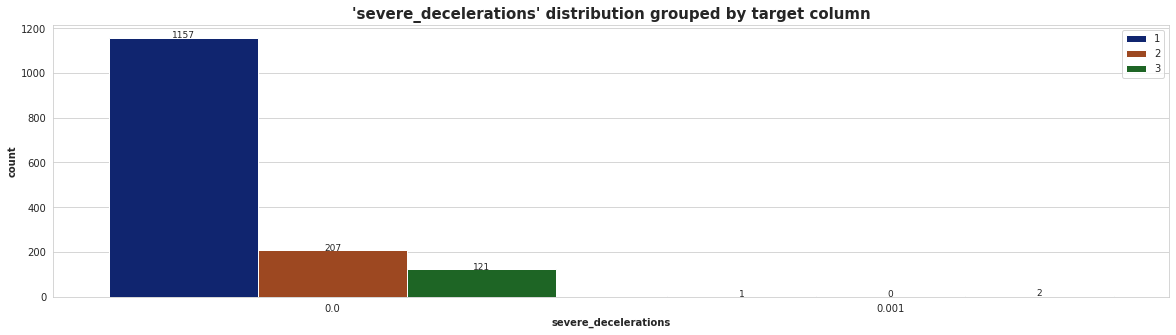

In [ ]:
explore_column('severe_decelerations', discrete=True)

Almost all records have the same value. Zero variance feature should be dropped.

In [ ]:
train['severe_decelerations'] = train['severe_decelerations'].apply(lambda x: x * 1000).astype('int')
test['severe_decelerations'] = test['severe_decelerations'].apply(lambda x: x * 1000).astype('int')

### prolongued_decelerations

Number of unique values: train - 6, test - 5

Unique values:
train - [0.0, 0.001, 0.002, 0.003, 0.004, 0.005]        
test - [0.0, 0.001, 0.002, 0.003, 0.004]

Unseen values in test set: False



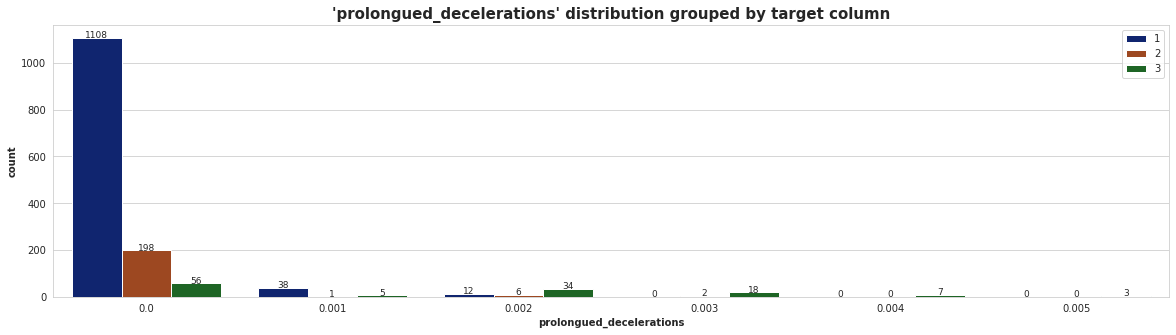

In [ ]:
explore_column('prolongued_decelerations', discrete=True)

Again, heavily imbalanced, but ratio of abnormal conditions is high for higher values of *prolongued_decelerations*.

In [ ]:
train['prolongued_decelerations'] = train['prolongued_decelerations'].apply(lambda x: x * 1000).astype('int')
test['prolongued_decelerations'] = test['prolongued_decelerations'].apply(lambda x: x * 1000).astype('int')

### abnormal_short_term_variability

Range of values: train - 12.0 to 87.0, test - 13.0 to 86.0

Mean: train - 46.7198, test - 47.6207
Median: train - 49.0, test - 48.0



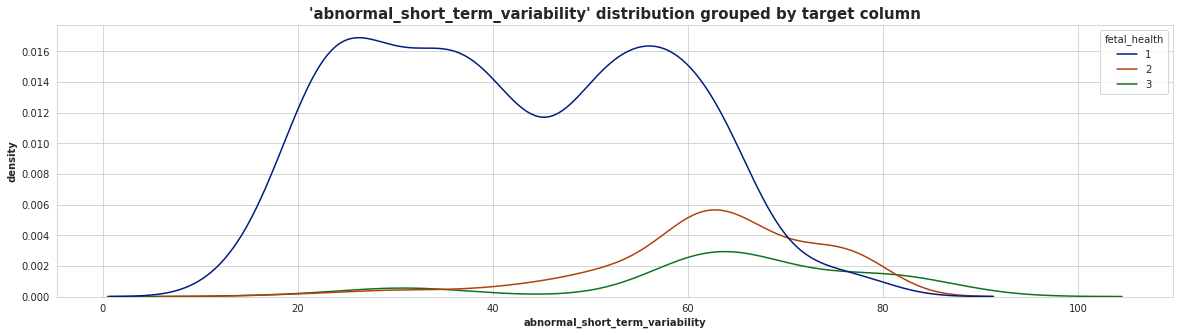

In [ ]:
explore_column('abnormal_short_term_variability', discrete=False)

Frequency of abnormal conditions is higher for higher values of the feature.

In [ ]:
train['abnormal_short_term_variability'] = train['abnormal_short_term_variability'].astype('int')
test['abnormal_short_term_variability'] = test['abnormal_short_term_variability'].astype('int')

### mean_value_of_short_term_variability

Range of values: train - 0.2 to 7.0, test - 0.2 to 6.9

Mean: train - 1.3430, test - 1.3089
Median: train - 1.2, test - 1.1



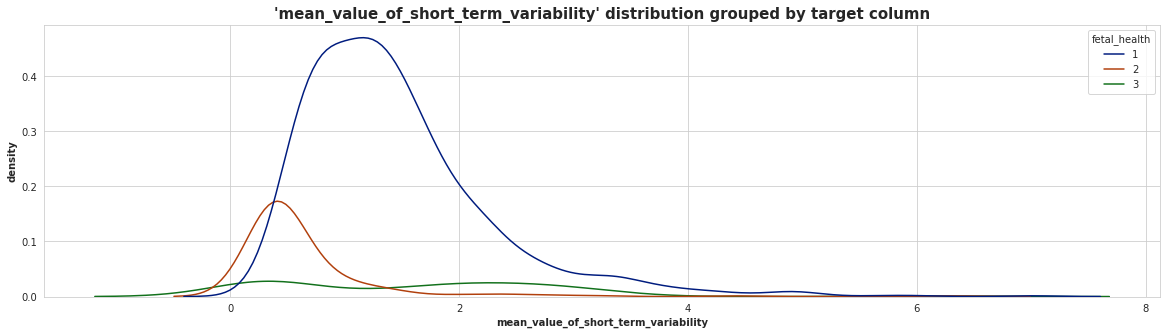

In [ ]:
explore_column('mean_value_of_short_term_variability', discrete=False)

### percentage_of_time_with_abnormal_long_term_variability

Range of values: train - 0.0 to 91.0, test - 0.0 to 91.0

Mean: train - 9.4704, test - 10.7241
Median: train - 0.0, test - 0.0



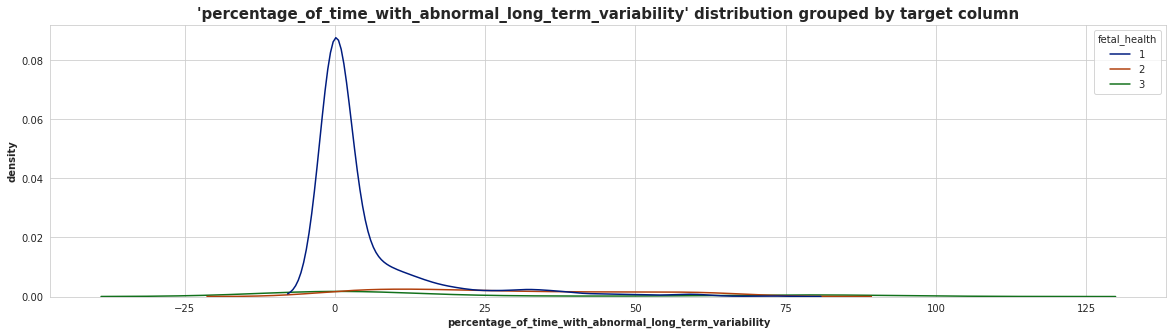

In [ ]:
explore_column('percentage_of_time_with_abnormal_long_term_variability', discrete=False)

In [ ]:
train['percentage_of_time_with_abnormal_long_term_variability'] = train['percentage_of_time_with_abnormal_long_term_variability'].astype('int')
test['percentage_of_time_with_abnormal_long_term_variability'] = test['percentage_of_time_with_abnormal_long_term_variability'].astype('int')

### mean_value_of_long_term_variability

Range of values: train - 0.0 to 50.7, test - 0.0 to 41.8

Mean: train - 8.2300, test - 8.0887
Median: train - 7.5, test - 7.2



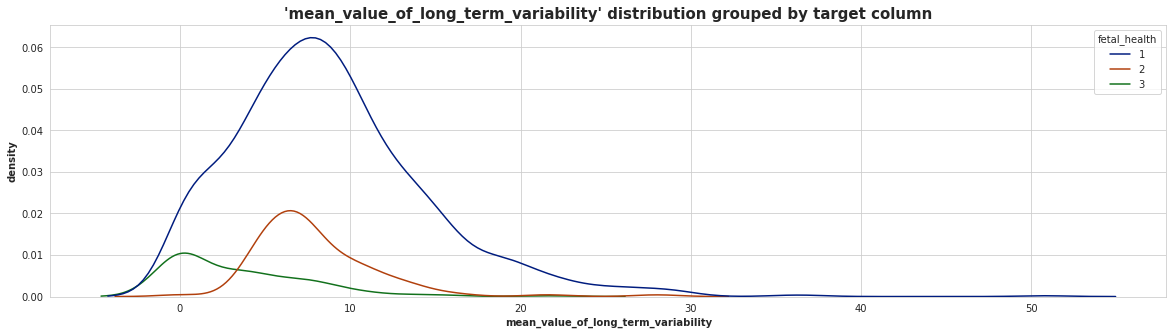

In [ ]:
explore_column('mean_value_of_long_term_variability', discrete=False)

### histogram_width

Range of values: train - 3.0 to 180.0, test - 3.0 to 176.0

Mean: train - 71.0531, test - 69.0298
Median: train - 68.0, test - 66.5



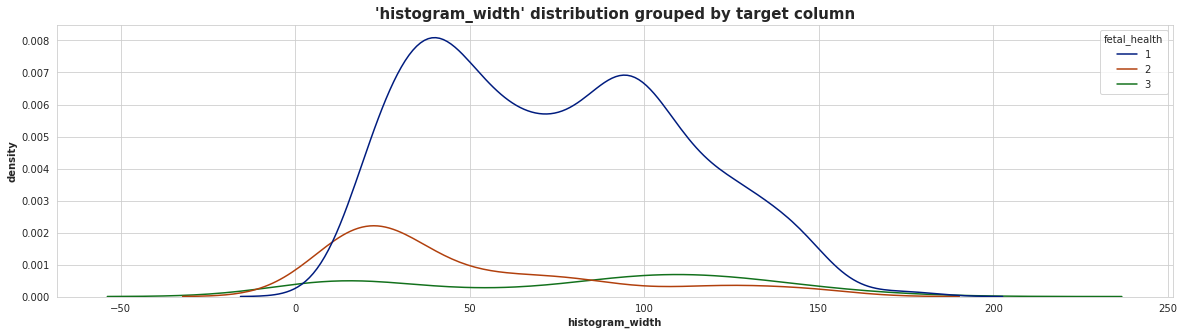

In [ ]:
explore_column('histogram_width', discrete=False)

In [ ]:
train['histogram_width'] = train['histogram_width'].astype('int')
test['histogram_width'] = test['histogram_width'].astype('int')

### histogram_min

Range of values: train - 50.0 to 158.0, test - 50.0 to 159.0

Mean: train - 93.0612, test - 94.7884
Median: train - 93.0, test - 95.0



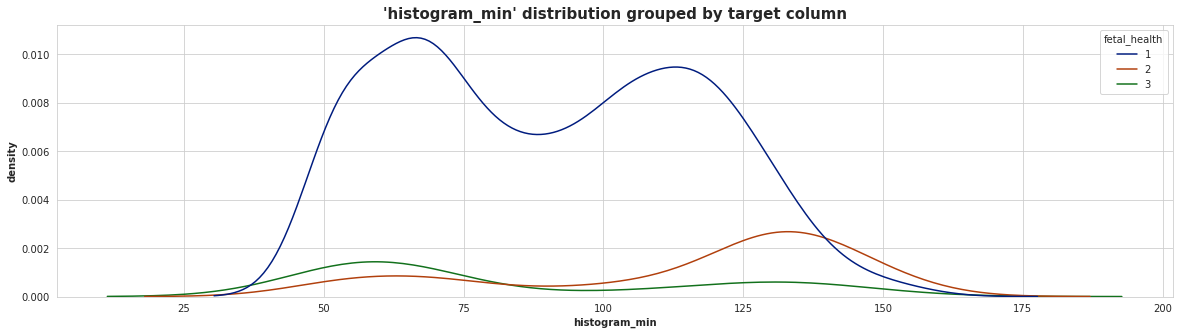

In [ ]:
explore_column('histogram_min', discrete=False)

In [ ]:
train['histogram_min'] = train['histogram_min'].astype('int')
test['histogram_min'] = test['histogram_min'].astype('int')

### histogram_max

Range of values: train - 122.0 to 238.0, test - 126.0 to 238.0

Mean: train - 164.1142, test - 163.8182
Median: train - 163.0, test - 161.0



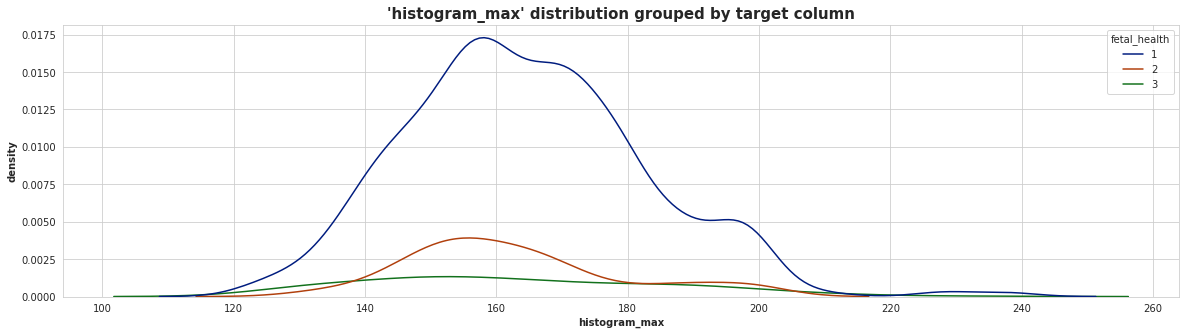

In [ ]:
explore_column('histogram_max', discrete=False)

In [ ]:
train['histogram_max'] = train['histogram_max'].astype('int')
test['histogram_max'] = test['histogram_max'].astype('int')

### histogram_number_of_peaks

Number of unique values: train - 18, test - 15

Unique values:
train - [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0]        
test - [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 16.0]

Unseen values in test set: False



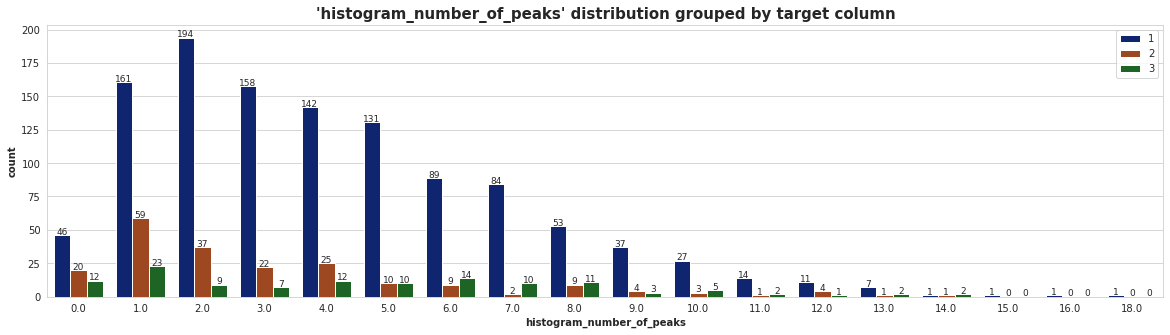

In [ ]:
explore_column('histogram_number_of_peaks', discrete=True)

In [ ]:
train['histogram_number_of_peaks'] = train['histogram_number_of_peaks'].astype('int')
test['histogram_number_of_peaks'] = test['histogram_number_of_peaks'].astype('int')

### histogram_number_of_zeroes

Number of unique values: train - 9, test - 4

Unique values:
train - [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 10.0]        
test - [0.0, 1.0, 2.0, 3.0]

Unseen values in test set: False



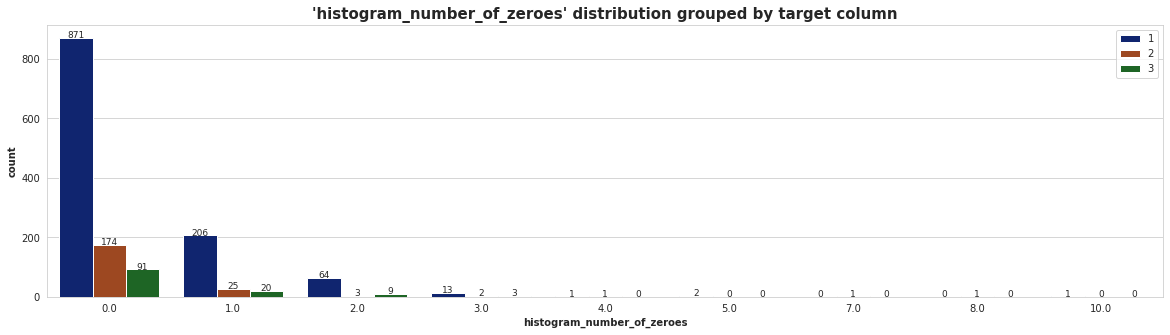

In [ ]:
explore_column('histogram_number_of_zeroes', discrete=True)

In [ ]:
train['histogram_number_of_zeroes'] = train['histogram_number_of_zeroes'].astype('int')
test['histogram_number_of_zeroes'] = test['histogram_number_of_zeroes'].astype('int')

### histogram_mode

Range of values: train - 60.0 to 187.0, test - 60.0 to 186.0

Mean: train - 137.3374, test - 137.7194
Median: train - 139.0, test - 139.0



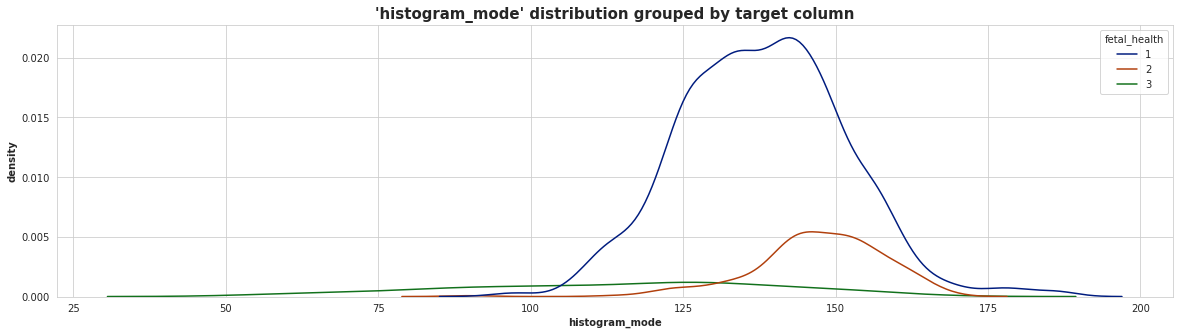

In [ ]:
explore_column('histogram_mode', discrete=False)

In [ ]:
train['histogram_mode'] = train['histogram_mode'].astype('int')
test['histogram_mode'] = test['histogram_mode'].astype('int')

### histogram_mean

Range of values: train - 76.0 to 182.0, test - 73.0 to 178.0

Mean: train - 134.4442, test - 134.9984
Median: train - 136.0, test - 136.0



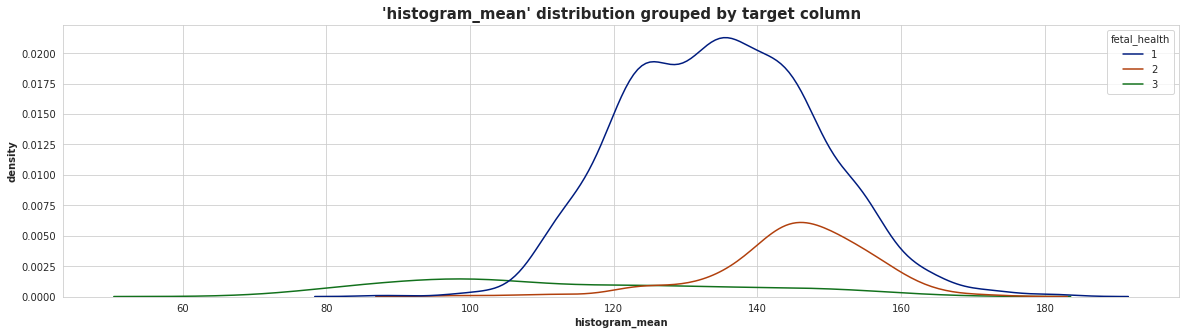

In [ ]:
explore_column('histogram_mean', discrete=False)

In [ ]:
train['histogram_mean'] = train['histogram_mean'].astype('int')
test['histogram_mean'] = test['histogram_mean'].astype('int')

### histogram_median

Range of values: train - 77.0 to 186.0, test - 79.0 to 180.0

Mean: train - 137.9724, test - 138.3652
Median: train - 139.0, test - 139.0



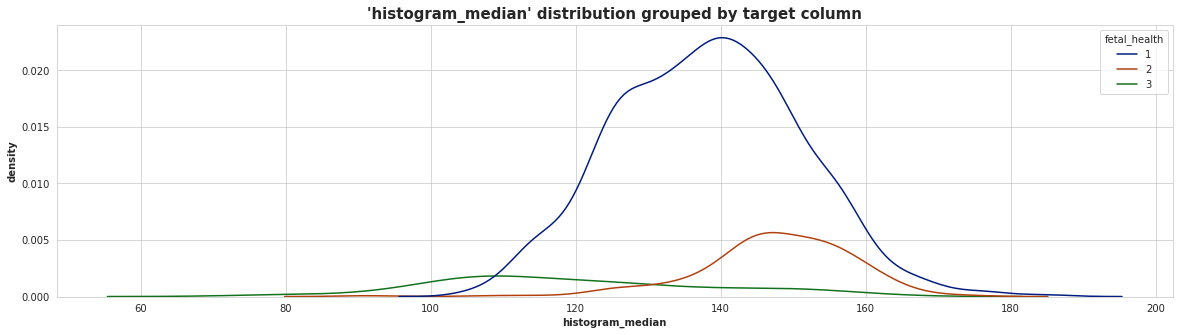

In [ ]:
explore_column('histogram_median', discrete=False)

In [ ]:
train['histogram_median'] = train['histogram_median'].astype('int')
test['histogram_median'] = test['histogram_median'].astype('int')

### histogram_variance

Range of values: train - 0.0 to 269.0, test - 0.0 to 190.0

Mean: train - 19.3320, test - 17.5862
Median: train - 8.0, test - 6.0



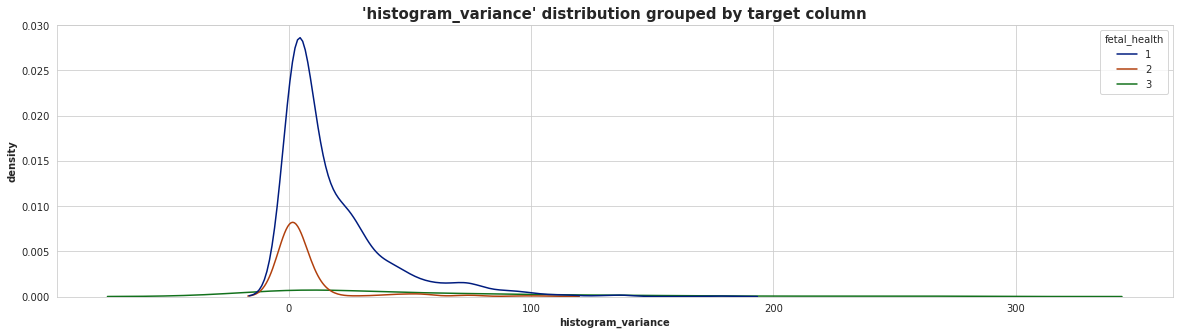

In [ ]:
explore_column('histogram_variance', discrete=False)

In [ ]:
train['histogram_variance'] = train['histogram_variance'].astype('int')
test['histogram_variance'] = test['histogram_variance'].astype('int')

### histogram_tendency

Number of unique values: train - 3, test - 3

Unique values:
train - [-1.0, 0.0, 1.0]        
test - [-1.0, 0.0, 1.0]

Unseen values in test set: False



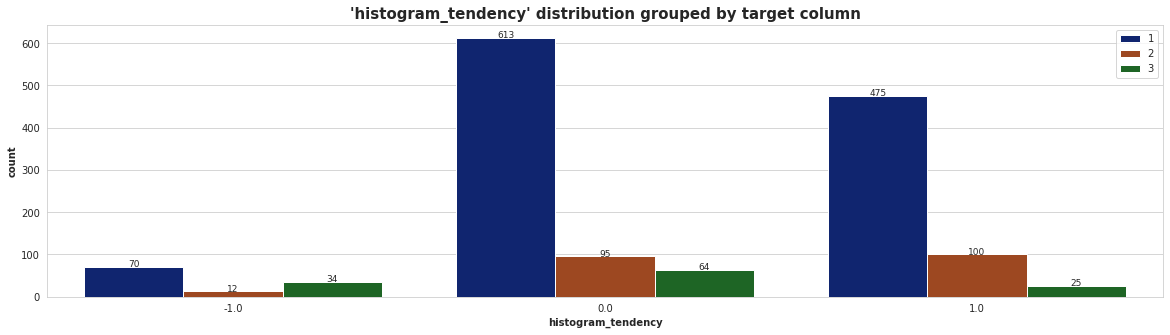

In [ ]:
explore_column('histogram_tendency', discrete=True)

In [ ]:
train['histogram_tendency'] = train['histogram_tendency'].apply(lambda x: x + 1).astype('int')
test['histogram_tendency'] = test['histogram_tendency'].apply(lambda x: x + 1).astype('int')

## Feature selection

In [ ]:
imbalanced_features = ['fetal_movement', 'light_decelerations', 
                       'severe_decelerations', 'histogram_variance',
                       'prolongued_decelerations', 'histogram_number_of_zeroes',
                       'percentage_of_time_with_abnormal_long_term_variability']

In [ ]:
cat_features = ['severe_decelerations', 'prolongued_decelerations', 
                'histogram_number_of_zeroes', 'histogram_tendency']

num_features = [f for f in features if f not in cat_features]

### Chi-squared test of independence (categorical-categorical)

In [ ]:
chi2_test = chi2(train[cat_features], train[TARGET])
display(pd.DataFrame(data={'chi2': chi2_test[0], 
                           'p-value': chi2_test[1]}, 
                     index=cat_features))

,chi2,p-value
severe_decelerations,13.5584,1.1372e-03
prolongued_decelerations,1171.9242,3.3105e-255
histogram_number_of_zeroes,3.5797,1.6699e-01
histogram_tendency,16.8148,2.2321e-04


*histogram_number_of_zeroes* is rejected as a feature.

### ANOVA-F test (continuous-categorical)

In [ ]:
anova_test = f_classif(train[num_features], train[TARGET])
display(pd.DataFrame(data={'f-statistic': anova_test[0], 
                           'p-value': anova_test[1]}, 
                     index=num_features))

,f-statistic,p-value
baseline value,108.8430,7.7531e-45
accelerations,137.3764,1.8156e-55
fetal_movement,19.7046,3.5807e-09
uterine_contractions,59.5735,1.2975e-25
light_decelerations,47.9899,6.3693e-21
abnormal_short_term_variability,244.9524,1.1584e-92
mean_value_of_short_term_variability,86.3954,3.2068e-36
percentage_of_time_with_abnormal_long_term_variability,249.9994,2.6297e-94
mean_value_of_long_term_variability,55.8269,4.1968e-24
histogram_width,46.7286,2.0846e-20


*histogram_max* is rejected as a feature.

### Mutual Information

In [ ]:
cat_mask = [f in cat_features for f in features] #boolean mask for discrete features
mi_scores = mutual_info_classif(train[features], train[TARGET], discrete_features=cat_mask, random_state=SEED)
display(pd.DataFrame(data={'mi_score': mi_scores}, index=features))

,mi_score
baseline value,0.1335
accelerations,0.1527
fetal_movement,0.0479
uterine_contractions,0.0758
light_decelerations,0.0459
severe_decelerations,0.0022
prolongued_decelerations,0.0970
abnormal_short_term_variability,0.2059
mean_value_of_short_term_variability,0.2183
percentage_of_time_with_abnormal_long_term_variability,0.1867


In [ ]:
rejected_features = ['histogram_max', 'histogram_number_of_zeroes']

# Modelling

In [ ]:
selected_features = [f for f in features if f not in rejected_features]

In [ ]:
balanced_features = [f for f in selected_features if f not in imbalanced_features]

In [ ]:
model = ExtraTreesClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    verbose=0)

### 1. All features

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train[features], 
                                              train[TARGET],
                                              stratify=train[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
model.fit(xtrain, ytrain)

ExtraTreesClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1)

In [ ]:
print(f"F1-score = {f1_score(yval, model.predict(xval), average='weighted')}")

F1-score = 0.9340060172810866


### 2. Selected features

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train[selected_features], 
                                              train[TARGET],
                                              stratify=train[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
model.fit(xtrain, ytrain)

ExtraTreesClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1)

In [ ]:
print(f"F1-score = {f1_score(yval, model.predict(xval), average='weighted')}")

F1-score = 0.9210279716592017


### 3. Balanced features

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train[balanced_features], 
                                              train[TARGET],
                                              stratify=train[TARGET],
                                              shuffle=True,
                                              random_state=SEED)

In [ ]:
model.fit(xtrain, ytrain)

ExtraTreesClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1)

In [ ]:
print(f"F1-score = {f1_score(yval, model.predict(xval), average='weighted')}")

F1-score = 0.9290723199441865


### Test predictions

In [ ]:
baseline = ExtraTreesClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    verbose=0)

baseline.fit(train[selected_features], train[TARGET])

ExtraTreesClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1)

In [ ]:
predictions = baseline.predict(test[selected_features])

In [ ]:
submission = pd.DataFrame({'fetal_health': predictions})
submission.to_csv('sub-baseline.csv', index=False)

In [ ]:
!head sub-baseline.csv

fetal_health
1
2
1
1
1
1
1
1
1
